University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela 

# Lecture 8: MCMC convergence and more MCMC tricks

Background reading: please see Chapter 8 of the "Course notes" available in Moodle.


## 1. Metropolis-Hastings MCMC with a fixed proposal

MCMC sampling with Metropolis-Hastings can also be used in a way that the proposal $q(x';x)$ is independent of $x$, that is $$q(x'; x) = q(x').$$ 
This resembles rejection sampling, except we do not need an explicit rejection threshold.

Write a Metropolis-Hastings (MH) sampler for the following cases, and as usual make histograms and trace plots:

1. First, sample via MH from the $\mathcal{N}(0,1)$ distribution using $\mathrm{Laplace}(0, 1)$ as the *fixed* proposal.
2. Second, sample via MH from the $\mathrm{Laplace}(0, 1)$ distribution using $\mathcal{N}(0,1)$ as the *fixed* proposal.

For both cases, compute the expectation $\mathrm{E}[x^2]$ and $\mathrm{E}[x^4]$ and compare it with the exact second and fourth moments of a normal and Laplace distributions, respectively.

- What do you observe?
- Can you explain what's going on with the tails of the Laplace distribution when you sample from it in case 2 (if you notice anything odd)?

*Hints*: 
- It is vital to include the $\frac{q(x;x')}{q(x';x)}$ term in the acceptance ratio now.
- For the comparison with the exact moments ($\mathrm{E}[x^2]$ and $\mathrm{E}[x^4]$), you can approximate the exact moments via simple Monte Carlo by sampling $n=10^5$ samples from a standard normal (`numpy.random.normal`) or Laplace distribution (`numpy.random.laplace`) as appropriate.

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

def laplacetarget(x):
    """Laplace log pdf."""
    return -np.log(2) - np.abs(x)

def normaltarget(x):
    """Normal log pdf (unnormalized)."""
    return -0.5*(x**2)

def mhsample(theta0, n, log_target, drawproposal, proposal = lambda x,y : 0):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (can be asymmetric).
    """    
    theta = theta0
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp + proposal(theta_prop, theta) - proposal(theta, theta_prop):
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

def make_plots(samples):
    """Make plots for samples."""
    plt.plot(samples)
    plt.xlabel(r'Iterations')
    plt.ylabel(r'$x$')
    plt.title(r'Trace plot of MCMC')
    plt.show()

    h = plt.hist(samples, 100, density=True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$p(x)$')
    plt.title(r'Histogram of MCMC samples')
    plt.show()

Acceptance rate: 0.8381


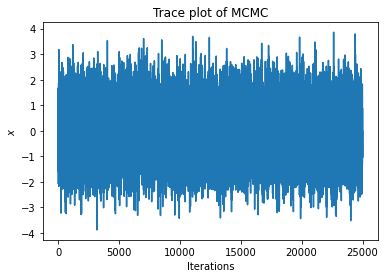

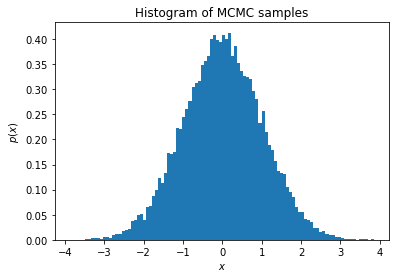

sampled E[x^2] and E[x^4] 1.0081143837193902 3.028844736637451
normal E[x^2] and E[x^4] 0.9992775638846226 2.9928488566027087


In [2]:
# 1 Sample from target normal using Laplace as proposal

npr.seed(43)
samples = mhsample(1.0, 50000, normaltarget, lambda x: npr.laplace(), lambda x,y: laplacetarget(y))
samples = samples[len(samples)//2:]

make_plots(samples)

print('sampled E[x^2] and E[x^4]', np.mean(samples**2), np.mean(samples**4))
y = npr.normal(size=300000)
print('normal E[x^2] and E[x^4]', np.mean(y**2), np.mean(y**4))

Acceptance rate: 0.8090666666666667


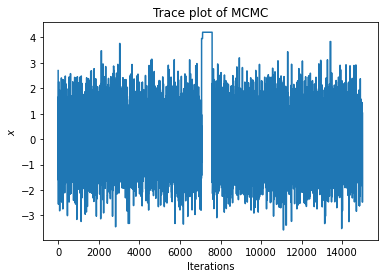

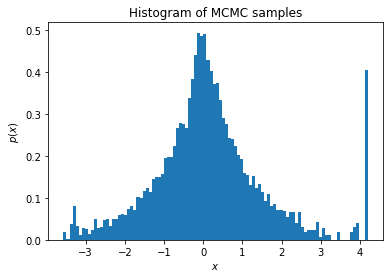

sampled E[x^2] and E[x^4] 2.027130907002497 18.21910336911901
Laplace E[x^2] and E[x^4] 2.0049956030495157 24.44034078481521


In [3]:
# 2 Sample from target Laplace with normal proposal

npr.seed(43)
samples = mhsample(1.0, 30000, laplacetarget, lambda x: npr.normal(), lambda x,y: normaltarget(y))
samples = samples[len(samples)//2:]

make_plots(samples)

print('sampled E[x^2] and E[x^4]', np.mean(samples**2), np.mean(samples**4))
y = npr.laplace(size=300000)
print('Laplace E[x^2] and E[x^4]', np.mean(y**2), np.mean(y**4))

# Note how the sampler gets stuck in the tails. Why?

## 2. Parallel tempering MCMC for multimodal distributions

We will experiment with parallel tempering MCMC for a bimodal distribution $$\pi(\theta) = \exp(- \gamma (\theta^2-1)^2).$$

For more details on parallel tempering, please see Sec. 8.3.2 and 8.3.3 of the course notes.

The basic idea of parallel tempering or Metropolis coupled MCMC is to run several chains in parallel for different annealed targets $\pi_\beta(\theta) = \pi(\theta)^\beta$ with $\beta \in [0,1]$. (In a Bayesian model, annealing would typically only be applied to the likelihood term, not to the full posterior.) When $\beta = 1$, this recovers the original target, whereas $\beta \rightarrow 0$ approaches a uniform distribution over the domain.

- The basic operation is to propose moves within each chain independently as usual.
- To get a benefit from the parallel chains, an additional operation is introduced which proposes the swapping of states between two neighbouring chains. 
  - These swaps are accepted or rejected according to the usual Metropolis-Hastings acceptance rule. 
  - The timing of the swap operations can be chosen freely, but in this problem proposing one swap after a round of indepedent steps for each chain seems to work well.

1. Implement a regular Metropolis-Hastings sampler for the target. Test it with $\gamma = 4, 16, 64$. Test with different proposal widths, aiming to achieve a reasonable acceptance rate. Plot the samples you obtain. For larger $\gamma$, can the sampler explore both modes of the distribution while at the same time having a reasonable acceptance rate?
2. Implement parallel tempering for the target with $\gamma = 64$. Run 5 chains with temperature schedule `betas = np.logspace(-3, 0, 5)`. (Feel free to try other alternatives as well.)

*Hint*: When writing the parallel tempering sampler, it is convenient to rescale the proposal step size $\sigma$ by $1/\sqrt{\beta}$. The rationale is that the same step size will hardly work on targets at different temperatures. The rescaling will help keep the step size approximately correct across chains at different temperatures.

In [4]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

def plot_results(samples,gamma):
    """Auxiliary function to plot results at a given gamma."""
    print('Mean: {} (gamma = {})'.format(np.mean(samples), gamma))
    h = plt.hist(samples, 50, density=True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$p(x)$')
    plt.title(r'MCMC samples ($\gamma = {}$)'.format(gamma))
    plt.show()
    
def target(x, gamma):
    """Bimodal target log pdf parametrized by gamma (unnormalized)."""
    return -gamma*(x**2-1)**2

Acceptance rate: 0.4349
Mean: 0.21791820886554225 (gamma = 4.0)


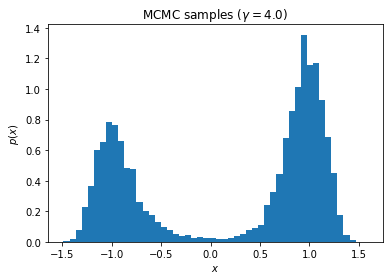

Acceptance rate: 0.2213
Mean: 0.9784098945336247 (gamma = 16.0)


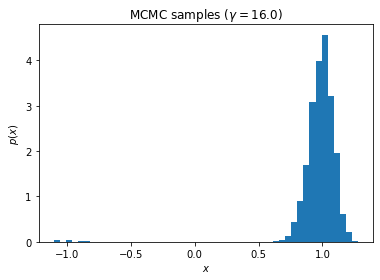

Acceptance rate: 0.1121
Mean: 0.9981035516763568 (gamma = 64.0)


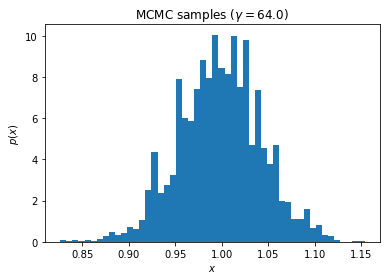

In [5]:
# 1
npr.seed(41)
gammas = [4.0, 16.0, 64.0]
sigma = 0.5

for gamma in gammas:
    samples = mhsample(1.0, 10000, lambda x: target(x, gamma), lambda x: x + sigma*npr.normal())
    plot_results(samples,gamma)

In [6]:
# 2

def par_mhsample(theta0, n, betas, target, drawproposal):
    """Parallel tempering Metropolis Hastings for target log pdf."""
    
    # Initialize variables
    num_chains = len(betas) # Number of chains equal to number of temperatures (betas)
    accepts = np.zeros(num_chains)
    swapaccepts = np.zeros(num_chains-1)
    swaps = np.zeros(num_chains-1)
    lp = np.zeros(num_chains)
    thetas = np.zeros((n, num_chains))
    
    theta = theta0 * np.ones(num_chains) # Copy starting point for all chains
    # Compute log density at starting point for each chain (at different temperatures)
    for j in range(num_chains):
        lp[j] = target(theta[j], betas[j])
        
    # Main sampling loop
    for i in range(n):
        
        # Independent moves for every chain
        for j in range(num_chains):
            theta_prop = drawproposal(theta[j], betas[j])
            l_prop = target(theta_prop, betas[j])
            if np.log(npr.rand()) < l_prop - lp[j]:
                theta[j] = theta_prop
                lp[j] = l_prop
                accepts[j] += 1
                
        # Swap move for two adjacent chains:
        j = npr.randint(num_chains-1)
        h = target(theta[j+1],betas[j])+target(theta[j],betas[j+1]) - lp[j] - lp[j+1]
        swaps[j] += 1
        if np.log(npr.rand()) < h:
            temp = theta[j]
            theta[j] = theta[j+1]
            theta[j+1] = temp
            lp[j] = target(theta[j], betas[j])
            lp[j+1] = target(theta[j+1], betas[j+1])
            swapaccepts[j] += 1
        thetas[i,:] = theta
    print('Acceptance rates:', accepts/n)
    print('Swap acceptance rates:', swapaccepts/swaps)
    return thetas[len(thetas)//2:]

Acceptance rates: [0.4654 0.6342 0.5601 0.4756 0.4598]
Swap acceptance rates: [0.75669    0.62305296 0.46216436 0.49941061]
Mean: 0.16770076291535405 (gamma = 64.0)


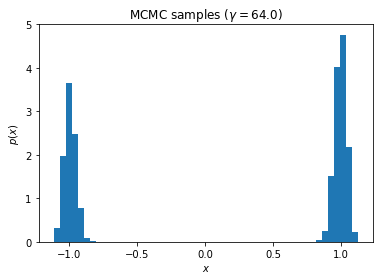

In [7]:
npr.seed(41)

# We apply the temperature rescaling to sigma in the proposal
sigma = 0.1
draw_proposal = lambda x, beta: x + sigma/np.sqrt(beta)*npr.normal()

betas = np.logspace(-3, 0, 5)
samples = par_mhsample(1.0, 10000, betas,
                      lambda x, beta: beta*target(x, 64.0),
                      draw_proposal)

# Plotting samples from the first chain (with beta = 1)
# Note that the other chains are sampling from a smoothed version of the target
plot_results(samples[:,-1],gamma)

## 3. Blocking in MCMC

Metropolis-Hastings sampling in high dimensions is difficult because one often needs to use very short jumps to keep the acceptance rate manageable. A common technique for managing this is *blocking*, where each proposal only updates a subset of the dimensions. This can lead to higher acceptance rates on longer jumps, but can also lead to difficulties if there are strong dependencies across block boundaries.

In this exercise we will experiment with blocking. We will sample from $d=100$ dimensional multivariate normals with two covariances:  

1. $\Sigma = I_d$.
2. A non-diagonal covariance. You can generate such a covariance with $\Sigma = A A^T + \epsilon I_d$, where all entries of $A \in \mathbb{R}^{d \times k}$ follow $\mathcal{N}(0, 1)$. $k=2$ and $\epsilon=0.1$ give some reasonable results, but feel free to explore other values too.

To numerically test your samplers, you can check how accurately they can estimate the mean (zero) of the target, especially when initialised to a non-zero value.

1. Apply Metropolis-Hastings sampling to sample from $\mathcal{N}(0, \Sigma)$ for high $d$, e.g. $d=1000, d=10000$ using a normal proposal $q(x'; x) = \mathcal{N}(x, \sigma^2 I_d)$. Observe how the dimensionality affects the width of the proposal required for a reasonable acceptance rate. Plot a trace of the samples along a few dimensions to see how the sampler proceeds.
2. Re-implement the same sampler using blocking to only propose moves that change a subset of the dimensions at the time and iterate sequentially between the dimensions. Experiment with different block sizes.

*Hint*: If you are up to a little coding exercise, implement the blocked proposal yourself. If you do not feel up to the task, feel free to use the example implementation below.

In [8]:
import numpy as np
import numpy.random as npr

class blocked_normal_proposal:
    """A class for a blocked normal proposal.
      p = blocked_normal_proposal(d, blocks)
    creates a proposal object yielding d-dimensional normal random numbers
    where each of the "blocks" blocks in turn follows N(0, I) when calling
      p.draw()
    """
    def __init__(self, d, blocks):
        self.d = d
        self.blocks = blocks
        self.curblock = 0
    
    def next_block_indices(self):
        I = np.zeros(self.d, bool)
        I[((self.curblock*self.d)//self.blocks):(((self.curblock+1)*self.d)//self.blocks)] = True
        self.curblock = (self.curblock + 1) % self.blocks
        return I
    
    def draw(self):
        res = np.zeros(self.d)
        I = self.next_block_indices()
        res[I] = npr.normal(size=np.sum(I))
        return res

# Initialize the blocked proposal sampler (dimension d and # blocks)
p = blocked_normal_proposal(d=6, blocks=3)

# Sequential draws from the blocked proposal (note it cycles through blocks of variables)
print(p.draw())
print(p.draw())
print(p.draw())
print(p.draw())

[1.33423137 0.45678986 0.         0.         0.         0.        ]
[ 0.          0.         -0.46446531  0.3172598   0.          0.        ]
[ 0.          0.          0.          0.         -0.04584155 -1.05313926]
[ 0.01202113 -1.37888217  0.          0.          0.          0.        ]


In [9]:
import numpy as np
import numpy.random as npr

def d_mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0 in arbitrary dimension.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """    
    theta = theta0
    d = len(theta0)
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros([n, d])
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

In [10]:
# 1 Multivariate normal with diagonal covariance

def mvnormtarget(x):
    """Target multivariate normal log pdf."""
    return -0.5*np.sum(x**2)

def sample_nd(d, samples=100000, width=1.0):
    """Perform MCMC sampling in d dimensions."""
    return d_mhsample(10*np.ones(d), samples, mvnormtarget, lambda x: x+width*npr.normal(size=d))

npr.seed(41)
samples = sample_nd(1000, 100000, 0.2)
samples = samples[samples.shape[0]//2:,:]

print('RMSE (diagonal covariance, unblocked): {}'.format(np.sqrt(np.mean(np.mean(samples, 0)**2))))

Acceptance rate: 0.02926
RMSE (diagonal covariance, unblocked): 0.7427476333423709


In [11]:
def sample_nd_blocked(d, blocks, samples=100000, width=1.0):
    p = blocked_normal_proposal(d, blocks)
    return d_mhsample(10*np.ones(d), samples, mvnormtarget, lambda x: x+width*p.draw())

npr.seed(41)
samples = sample_nd_blocked(1000, 500, 100000, 1)

print('RMSE (diagonal covariance, unblocked): {}'.format(np.sqrt(np.mean(np.mean(samples, 0)**2))))

Acceptance rate: 0.54779
RMSE (diagonal covariance, unblocked): 1.0772375479082372


Acceptance rate: 0.4713
RMSE (full covariance, unblocked): 0.9887929240483434


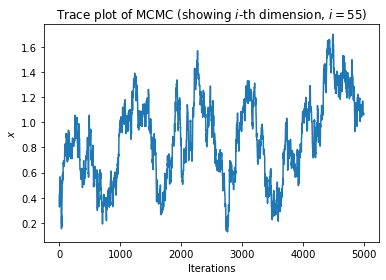

In [12]:
# 2 Full covariance matrix

import numpy as np
import numpy.random as npr
import numpy.linalg as nlg
import scipy.linalg as slg

A = npr.normal(size=(100, 2))
Sigma = A @ A.T + 0.1*np.eye(100)
M = nlg.cholesky(Sigma)

def mvnormtarget2(x):
    """Target multivariate normal log pdf with full covariance."""
    return -0.5*np.sum(slg.solve_triangular(M, x, lower=True)**2)

def sample_nd2(d, samples=100000, width=1.0):
    """MCMC sample from target."""
    samples = d_mhsample(10*np.ones(d), samples, mvnormtarget2, lambda x: x+width*npr.normal(size=d))
    return samples[len(samples)//2:]

def sample_nd2_blocked(d, blocks, samples=100000, width=1.0):
    """MCMC sample from target with blocked proposal."""
    p = blocked_normal_proposal(d, blocks)
    samples = d_mhsample(10*np.ones(d), samples, mvnormtarget2, lambda x: x+width*p.draw())
    return samples[len(samples)//2:]

npr.seed(42)
samples = sample_nd2(100, 10000, 0.05)

print('RMSE (full covariance, unblocked): {}'.format(np.sqrt(np.mean(np.mean(samples, 0)**2))))

i = 55
plt.plot(samples[:,i])
plt.xlabel(r'Iterations')
plt.ylabel(r'$x$')
plt.title(r'Trace plot of MCMC (showing $i$-th dimension, $i = {}$)'.format(i))
plt.show()


Acceptance rate: 0.2782
RMSE (full covariance, blocked): 0.7360656593895788


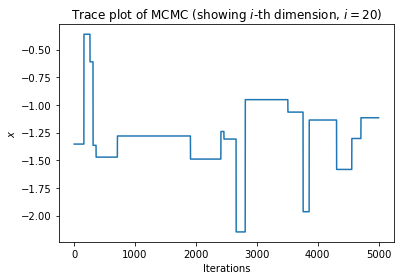

In [13]:
npr.seed(41)
samples = sample_nd2_blocked(100, 50, 10000, 0.8)

print('RMSE (full covariance, blocked): {}'.format(np.sqrt(np.mean(np.mean(samples, 0)**2))))

i = 20
plt.plot(samples[:,i])
plt.xlabel(r'Iterations')
plt.ylabel(r'$x$')
plt.title(r'Trace plot of MCMC (showing $i$-th dimension, $i = {}$)'.format(i))
plt.show()